# Modelo basado en transformers
En los modelos considerados anteriormente hemos llegado a alcanzar resultados excelentes. FastText clasifica perfectamente todas las frases con más de 12 palabras y llegamos a obtener tasas de acierto de 99.87% en frases de entre 7 y 12 palabras y del 98.37% en frases de menos de 7 palabras, manteniendo una latencia muy baja. Sin embargo, hemos visto que el modelo comete fallos que un humano no cometería derivados del hecho de que solo se fija en los n-gramas que tiene en su vocabulario, sin considerar palabras completas, y de que carece de mecanismos de atención. En este último enfoque, exploraremos si podemos solucionar estas limitaciones empleando un modelo BERT preentrenado en diversas lenguas. 

Emplearemos le modelo `distilbert-base-multilingual-cased` por varias razones:
- Está preentrenado sobre 104 lenguas, que incluyen todas las de nuestro dataset.
- Es más ligero que el modelo BERT original.
- Es *case-sensitive*, ya que sabemos que en algunos idiomas tienen un uso particular de las mayúsculas y minúsculas.

In [48]:
# # Librerías necesarias
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn.preprocessing import LabelEncoder
from transformers import TFDistilBertModel, DistilBertTokenizer
from livelossplot import PlotLossesKerasTF

## 1. Preprocesamiento de los datos

### Lectura y prepraración de los datos
Comenzamos leyendo las particiones de entrenamiento, validación y test que habíamos creado previamente. 

In [ ]:
# Leemos los datos
df_train = pd.read_csv(os.path.join("data","raw","train.csv"))
df_val = pd.read_csv(os.path.join("data","raw","val.csv"))
df_test = pd.read_csv(os.path.join("data","raw","test.csv"))

# Veamos nuestro DataFrame
df_train.head(5)

# Separamos las variables que usaremos
train_texts = df_train["text"]
val_texts = df_val["text"]
test_texts = df_test["text"]

y_train = df_train["language"]
y_val = df_val["language"]
y_test = df_test["language"]

### Tokenización y vectorización

In [ ]:
# Tokenizar los datasets (se truncan al tamaño de la ventana)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors='tf')
X_val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, return_tensors='tf')
X_test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, return_tensors='tf')

# Codificamos la variable objetivo
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

y_train_tensor = tf.convert_to_tensor(y_train_enc)
y_val_tensor = tf.convert_to_tensor(y_val_enc)
y_test_tensor = tf.convert_to_tensor(y_test_enc)

### Creación de tf.Dataset
Mejora la eficiencia durante el entrenamiento

In [46]:
# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_encodings['input_ids'],
        'attention_mask': X_train_encodings['attention_mask']
    },
    y_train_tensor
)).shuffle(len(X_train_encodings)).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_val_encodings['input_ids'],
        'attention_mask': X_val_encodings['attention_mask']
    },
    y_val_tensor
)).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_encodings['input_ids'],
        'attention_mask': X_test_encodings['attention_mask']
    },
    y_test_tensor
)).batch(32).prefetch(tf.data.AUTOTUNE)

## 2. Definición del modelo

In [ ]:
# # Número de idiomas
# num_classes = y_train.nunique()

# # Tamaño de la representación oculta de DistilBERT
# hidden_size = 768  

# # Cargamos el modelo preentrenado
# distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
# distilbert_model.trainable = False  # Congelamos sus pesos

# # Entradas del modelo: IDs de los tokens y máscara de atención
# input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
# attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')  # Indica qué tokens son padding

# # Función que aplica mean pooling sobre los embeddings de la secuencia
# @register_keras_serializable()
# def mean_pooling(inputs):
#     input_ids, attention_mask = inputs
#     outputs = distilbert_model(input_ids, attention_mask=attention_mask, return_dict=True)
#     last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

#     # Expandimos la máscara de atención para aplicar como máscara
#     input_mask_expanded = tf.cast(tf.expand_dims(attention_mask, -1), tf.float32)  # (batch_size, seq_len, 1)

#     # Aplicamos la máscara a los embeddings
#     sum_embeddings = tf.reduce_sum(last_hidden_state * input_mask_expanded, axis=1)  # (batch_size, hidden_size)
#     sum_mask = tf.reduce_sum(input_mask_expanded, axis=1)  # (batch_size, 1)

#     # Evitar división por cero
#     mean_embeddings = sum_embeddings / tf.maximum(sum_mask, 1e-9)  # (batch_size, hidden_size)

#     return mean_embeddings

# # Aplicar mean pooling usando una capa Lambda
# mean_pooled = tf.keras.layers.Lambda(mean_pooling, output_shape=(hidden_size,))([input_ids, attention_mask])

# # Cabeza para hacer la clasificación
# x = tf.keras.layers.Dense(256, activation='relu')(mean_pooled)
# x = tf.keras.layers.Dropout(0.2)(x)
# output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# # Construcción del modelo final
# model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)




In [ ]:
# Número de idiomas
num_classes = y_train.nunique()

# Tamaño de la representación oculta de DistilBERT
hidden_size = 768  

# Cargar modelo DistilBERT preentrenado
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
distilbert_model.trainable = False  # Congelamos sus pesos

# Entradas
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

# --- MeanPooling Layer personalizada ---
# Dado que estamos el modelo sin hacer finetuning y en distilbert el token [CLS]
# no se ha usado durante el entrenamiento, emplearemos la media de los embedding
# de las palabras 
class MeanPooling(tf.keras.layers.Layer):
    def call(self, hidden_states, attention_mask):
        mask = tf.cast(tf.expand_dims(attention_mask, -1), tf.float32)  # (batch, seq_len, 1)
        masked_hidden = hidden_states * mask
        sum_hidden = tf.reduce_sum(masked_hidden, axis=1)  # (batch, hidden_size)
        sum_mask = tf.reduce_sum(mask, axis=1)  # (batch, 1)
        return sum_hidden / tf.maximum(sum_mask, 1e-9)  # evitar división por 0

# Extraemos los embeddings de DistilBERT
bert_outputs = distilbert_model(input_ids, attention_mask=attention_mask, return_dict=True)
sequence_output = bert_outputs.last_hidden_state  # (batch, seq_len, hidden_size)

# Aplicamos mean pooling
mean_pooled = MeanPooling()(sequence_output, attention_mask)

# Clasificación
x = tf.keras.layers.Dense(256, activation='relu')(mean_pooled)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Modelo final
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [15]:
# Compilamos el modelo
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Veámoslo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   1347340   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, None, 768   80         'attention_mask[0][0]']      
                             ),                                                               

## 3. Entrenamiento de la cabeza del modelo
Antes de hacer fine-tuning del modelo, vamos a entrenar la cabeza clasificadora.

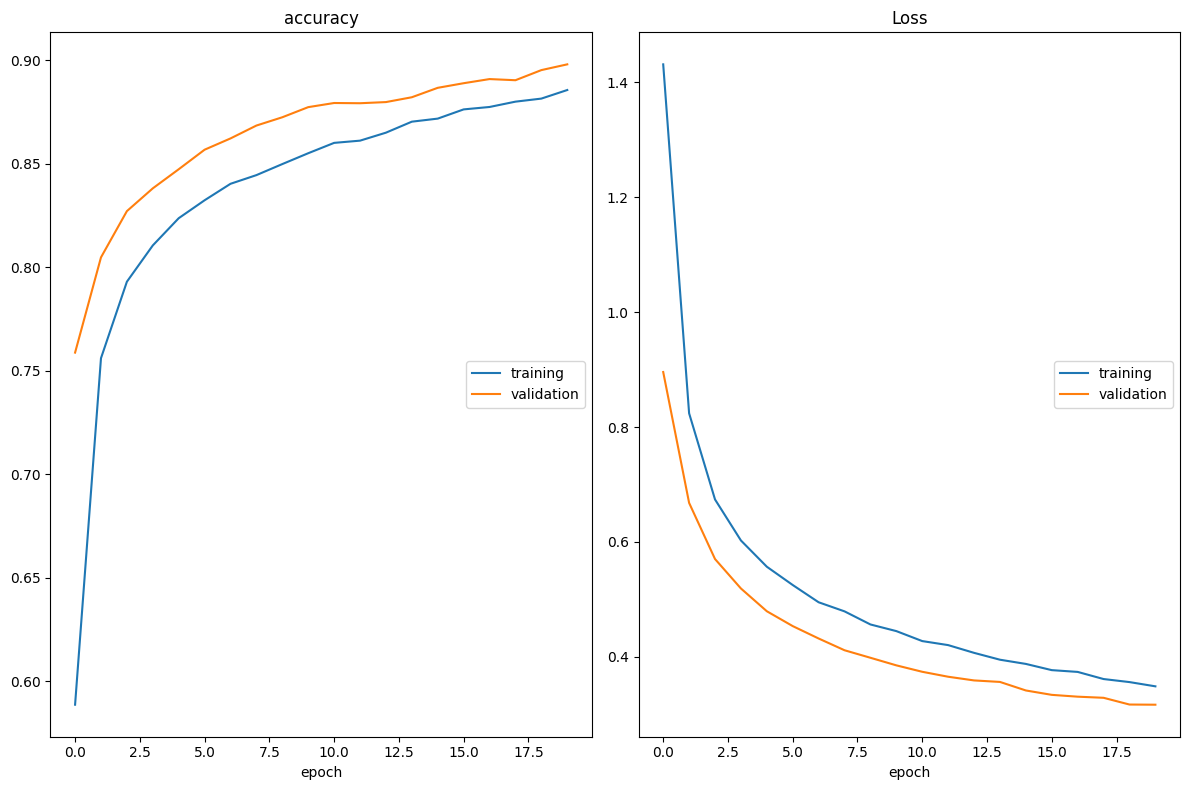

accuracy
	training         	 (min:    0.589, max:    0.886, cur:    0.886)
	validation       	 (min:    0.759, max:    0.898, cur:    0.898)
Loss
	training         	 (min:    0.349, max:    1.431, cur:    0.349)
	validation       	 (min:    0.317, max:    0.896, cur:    0.317)
1313/1313 [==============================] - 215s 164ms/step - loss: 0.3486 - accuracy: 0.8856 - val_loss: 0.3166 - val_accuracy: 0.8980


In [17]:
# Definir el callback de Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=2,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

Continuamos entrenando...

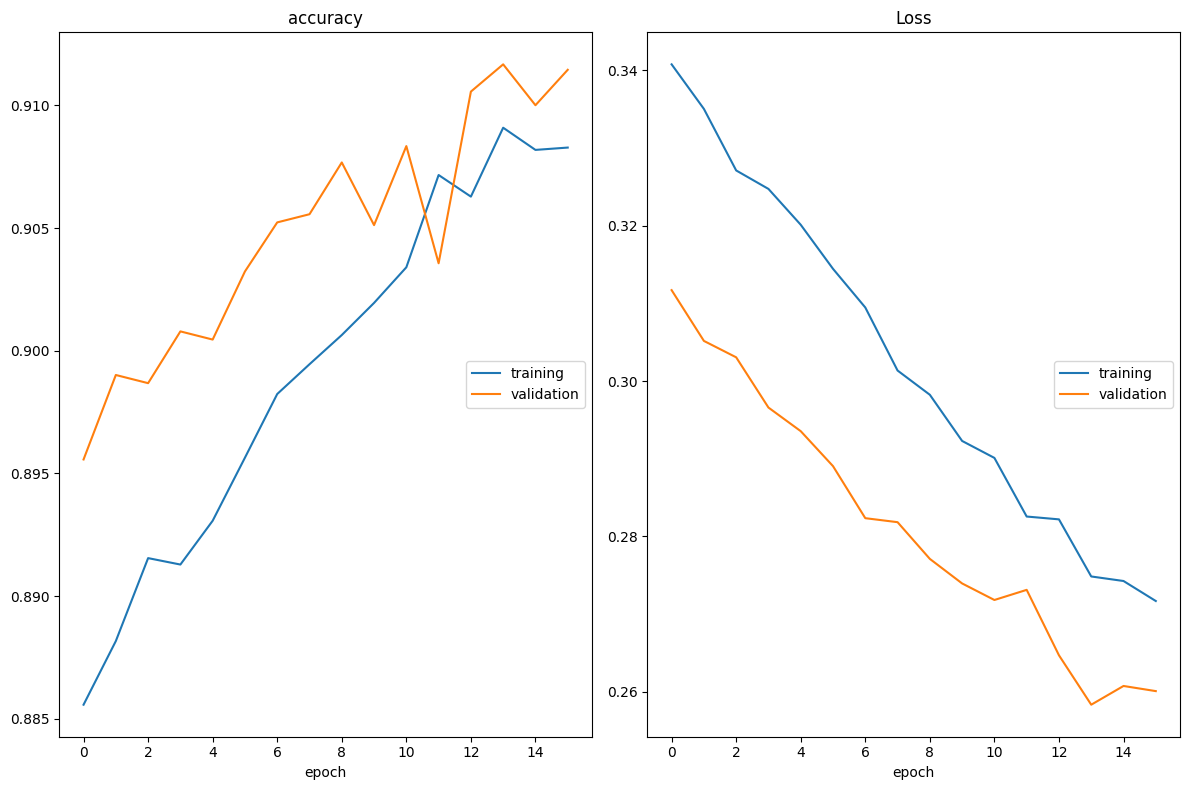

accuracy
	training         	 (min:    0.886, max:    0.909, cur:    0.908)
	validation       	 (min:    0.896, max:    0.912, cur:    0.911)
Loss
	training         	 (min:    0.272, max:    0.341, cur:    0.272)
	validation       	 (min:    0.258, max:    0.312, cur:    0.260)
1313/1313 [==============================] - 212s 161ms/step - loss: 0.2717 - accuracy: 0.9083 - val_loss: 0.2601 - val_accuracy: 0.9115


In [21]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

### Guardar el modelo

In [ ]:
# Creamos el directorio si no existe
model_dir = os.path.join("models","bert")
os.makedirs(model_dir, exist_ok=True)

# Guardamos el modelo entrenado
joblib.dump(model, os.path.join(model_dir,'bert_model.joblib'))

/home/juan/miniconda3/envs/tf_complete/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


['models/bert/bert_model.joblib']

## 4. Fine-tuning del encoder 
Una vez que los pesos de la cabeza ya están más o menos ajustados, vamos a hacer fine-tuning de los dos últimos bloques del transformer (y de la cabeza clasificadora).

In [38]:
# Descongela todo el modelo primero
distilbert_model.trainable = True

# Congela las primeras 4 capas del encoder
# Solo haremos fine-tuning de las 2 últimas
for i in range(4):
    distilbert_model.distilbert.transformer.layer[i].trainable = False

# Veamos que ahora el número de parámetros entrenables ha aumentado
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   1347340   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, None, 768   80         'attention_mask[0][0]']      
                             ),                                                               

In [ ]:
# Compilar el modelo
# Empleamos Adam con Weight Decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-5)  # Más bajo que el usado para entrenar la cabeza
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

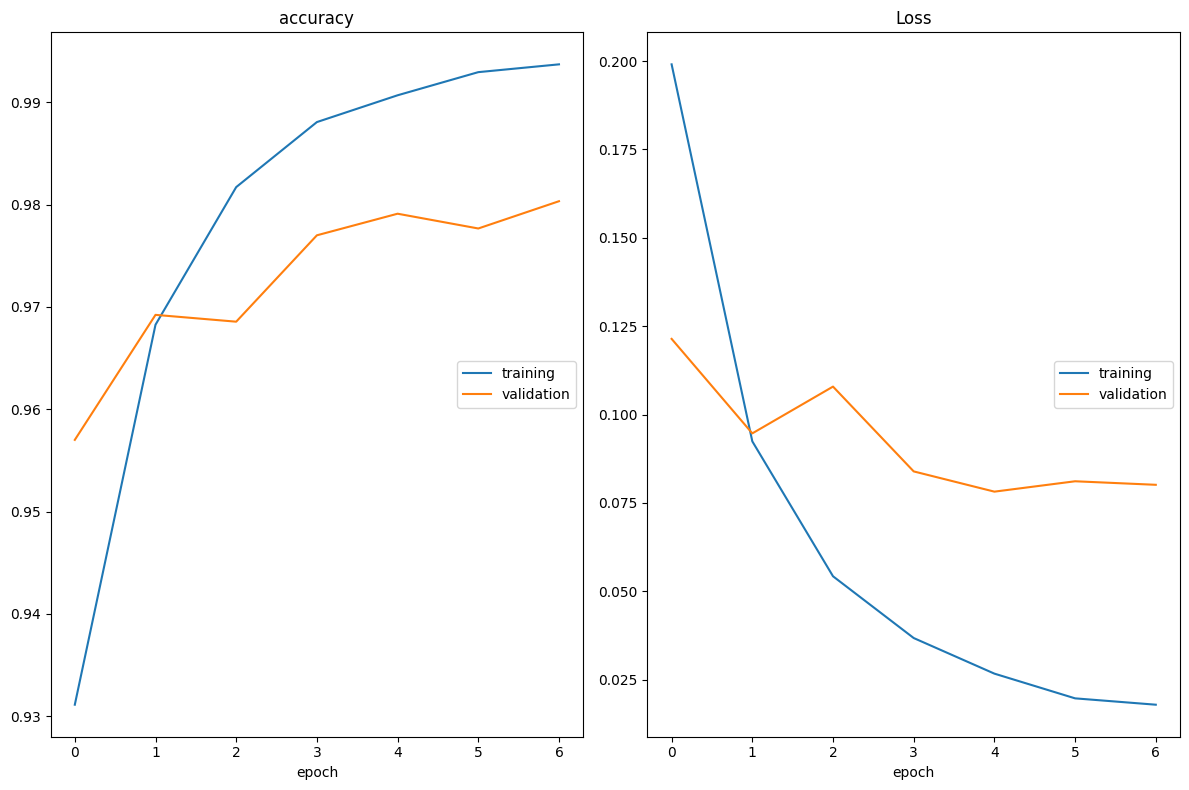

accuracy
	training         	 (min:    0.931, max:    0.994, cur:    0.994)
	validation       	 (min:    0.957, max:    0.980, cur:    0.980)
Loss
	training         	 (min:    0.018, max:    0.199, cur:    0.018)
	validation       	 (min:    0.078, max:    0.121, cur:    0.080)
1313/1313 [==============================] - 441s 336ms/step - loss: 0.0179 - accuracy: 0.9937 - val_loss: 0.0801 - val_accuracy: 0.9803


In [43]:
# Entrenamos el modelo

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

Reducir el tamaño de batch durante el entrenamiento, reducir la tasa de aprendizaje, aumentar la tasa de Dropout y aumentar la tasa de regularización podrian  ayudar a combatir el sobreajuste, llegando a alcanzar rendimientos superiores. Igualmente, emplear modelos de mayor tamaño y datasets mayores podrían ayudar también a superar el rendimiento de los demás modelos considerados. Las limitaciones computacionales de este trabajo impiden explorar estas alternativas, por lo que se dejará como trabajo futuro.

### Guardar el modelo

In [44]:
# Creamos el directorio si no existe
model_dir = os.path.join("models","bert")
os.makedirs(model_dir, exist_ok=True)

# Guardamos el modelo entrenado
joblib.dump(model, os.path.join(model_dir,'bert_model_fine_tuned.joblib'))

/home/juan/miniconda3/envs/tf_complete/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


['models/bert/bert_model_fine_tuned.joblib']

## 5. Evaluación

In [47]:
import time
from utils import classification_metrics_report

# Hacemos las predicciones monitoreando la latencia del modelo
start = time.time()
preds = model.predict(test_dataset)
end = time.time()

preds_class = preds.argmax(axis = 1)
preds_str = le.inverse_transform(preds_class)

# Empleamos una función personalizada para ver un report del rendimiento
results_fasttext = classification_metrics_report(y_test, preds_str, df_test["n_words"])

# Latencia
latency_ms = (end - start) * 1000  # milisegundos
print(f"Latencia: {latency_ms:.2f} ms")

282/282 [==============================] - 80s 279ms/step
=== Global Metrics ===
 accuracy  precision_macro  recall_macro  f1_macro
 0.979113         0.979269      0.978972  0.979061

=== Per-Class Metrics ===
label  precision   recall       f1  support
   cs   0.966713 0.965374 0.966043      722
   da   0.979784 0.974531 0.977151      746
   de   0.983095 0.992126 0.987590      762
   el   1.000000 0.998636 0.999317      733
   es   0.984419 0.955983 0.969993      727
   fi   0.978697 0.994904 0.986734      785
   fr   0.965161 0.985507 0.975228      759
   it   0.977120 0.979757 0.978437      741
   pl   0.995833 0.974185 0.984890      736
   pt   0.983806 0.966844 0.975251      754
   sl   0.961691 0.982456 0.971963      741
   sv   0.974906 0.977358 0.976131      795

=== Metrics Per Size ===
  size  accuracy  precision_macro  recall_macro  f1_macro
 large  0.995614         0.995623      0.995672  0.995631
medium  0.986857         0.986949      0.986756  0.986823
 small  0.934122  

Lo primero y más evidente es que la latencia del modelo es mucho más alta que en los anteriores (40 veces más). También, hay que tener en cuenta que el modelo pesa mucho más y su entrenamiento lleva varias horas. Es necesario decir, que probablemente se podrían llegar a obtener mejores resultados si aplicásemos más regularización para evitar el sobreajuste.

## 6. Análisis de errores

In [50]:
def sorted_dict_probs(pred_probs:np.array):
    
    return dict(sorted(zip(le.classes_,np.round(pred_probs,3)), key=lambda x: x[1], reverse=True))

In [51]:
# Nos centramos en los errores
df_errors = df_test[preds_class!=y_test_enc].copy()

# Añadimos la clase predicha
df_errors.loc[:,"pred"] = [pred for pred, true in zip(preds_str, y_test) if pred != true]

# Añadimos las probabilidades
df_errors.loc[:,"scores"] = [sorted_dict_probs(preds[i]) for i in range(len(test_texts)) if preds_str[i]!=y_test[i]]

# Veamos los errores
df_errors

,text,language,n_words,pred,scores
46,To je příliš mnoho.\n,cs,4,sl,"{'sl': 0.595, 'cs': 0.405, 'da': 0.0, 'de': 0...."
85,Tusindvis af tons små fisk kasseres hvert år i...,da,10,fi,"{'fi': 0.734, 'da': 0.206, 'sv': 0.026, 'sl': ..."
127,"Podes estar calado, moço.\n",pt,4,es,"{'es': 0.766, 'da': 0.183, 'pt': 0.042, 'fr': ..."
154,Espero que estas formas de discriminación ling...,es,12,pt,"{'pt': 0.995, 'es': 0.005, 'cs': 0.0, 'da': 0...."
230,Není tu žádná.\n,cs,3,sl,"{'sl': 0.557, 'cs': 0.443, 'da': 0.0, 'de': 0...."
...,...,...,...,...,...
8845,La Commissione rimarrà silente?\n,it,4,fr,"{'fr': 0.999, 'it': 0.001, 'cs': 0.0, 'da': 0...."
8864,Haverá capítulos separados.\n,pt,3,fr,"{'fr': 0.876, 'pt': 0.088, 'cs': 0.031, 'pl': ..."
8867,"Toiseksi, pk-yritysten rahoittaminen.\n",fi,4,cs,"{'cs': 0.668, 'fi': 0.222, 'sl': 0.11, 'da': 0..."
8954,A catástrofe no Reino Unido é já enorme.\n,pt,8,cs,"{'cs': 0.587, 'es': 0.345, 'pt': 0.05, 'fr': 0..."


El modelo tal cual está no está, ni mucho menos a la altura de los anteriores. Necesita más entrenamiento y para eso hay que mitigar el sobreajuste. No tiene sentido evaluar los errores que produce porque aún son demasiados

### Pruebas
Hacemos algunas pruebas para ver el funcionamiento del modelo

In [56]:
text= "Hola buenos días" # Español
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 1s 847ms/step
Idioma detectado: fr


,pred_probs
cs,0.01
da,0.00
de,0.00
el,0.00
es,0.21
fi,0.01
fr,0.61
it,0.01
pl,0.01
pt,0.04


In [57]:
text= "Cómo" # Español
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 1s 802ms/step
Idioma detectado: sl


,pred_probs
cs,0.01
da,0.00
de,0.00
el,0.00
es,0.09
fi,0.00
fr,0.01
it,0.02
pl,0.30
pt,0.09


In [58]:
text = "Nicht" # Alemán 
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 0s 59ms/step
Idioma detectado: de


,pred_probs
cs,0.01
da,0.00
de,0.98
el,0.00
es,0.00
fi,0.00
fr,0.00
it,0.00
pl,0.00
pt,0.00


In [59]:
text = "Ça ne marche pas" # Francés 
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 0s 59ms/step
Idioma detectado: fr


,pred_probs
cs,0.00
da,0.00
de,0.00
el,0.00
es,0.00
fi,0.00
fr,0.99
it,0.01
pl,0.00
pt,0.00


In [60]:
text = "Ça ne marche pas, je suis desolé" # Francés 
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 0s 58ms/step
Idioma detectado: fr


,pred_probs
cs,0.0
da,0.0
de,0.0
el,0.0
es,0.0
fi,0.0
fr,1.0
it,0.0
pl,0.0
pt,0.0


In [61]:
text = "Det fungerar inte." # Sueco
tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred_probs = model.predict({
    'input_ids': tokenized_text['input_ids'],
    'attention_mask': tokenized_text['attention_mask']
})

df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 [==============================] - 0s 57ms/step
Idioma detectado: sv


,pred_probs
cs,0.0
da,0.0
de,0.0
el,0.0
es,0.0
fi,0.0
fr,0.0
it,0.0
pl,0.0
pt,0.0
